<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - User Story 4
### On-demand processing of Sentinel-2 data:
 - ARD compliant
 - With custom parametrization

1. Visualize on-demand Sentinel-2 data, EODC (Force) Vito (iCor).
2. EODC has terrain correction with Force. Show differences between Force (has terrain correction) and iCor in mountain areas. Same area as before maybe.
3. Visualize performance/measure time when bbox over two tiles and compare when only above one tile.
4. Visualize metadata

### Performance: live demo or another view from the back-end side showing the load?

In [14]:
from openeoPlatform import *

## Select the area of interest in the next map

In [15]:
center = [46.49, 11.38]
zoom = 11

eoMap = openeoMap(center,zoom)
eoMap.map

Map(center=[46.49, 11.38], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

## openEO graph creation and processing

1. Open the connection with VITO back-end

In [21]:
connection = openeo.connect("https://openeo-dev.vito.be").authenticate_basic('guest','guest123')

2. Define range of interest in time and requested bands from Sentinel-2 L1C data

In [22]:
collection      = 'SENTINEL2_L1C_SENTINELHUB'
spatial_extent  = {'west':eoMap.bbox[0],'east':eoMap.bbox[2],'south':eoMap.bbox[1],'north':eoMap.bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2019-09-18", "2019-09-20"]
bands           = ["B02","B03","B04","B08","CLM","B09","B8A","B11",'sunAzimuthAngles','sunZenithAngles','viewAzimuthMean','viewZenithMean']

l1c_bands = connection.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

3. Apply atmospheric correction (iCor)

In [ ]:
l2a_icor = l1c_bands.atmospheric_correction()
# l2a_icor = l1c_bands.ard_surface_reflectance(atmospheric_correction_method=None,cloud_detection_method=None)

54. Visualize the openEO process graph

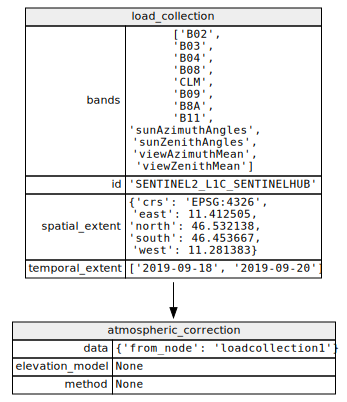

In [19]:
l2a_icor.to_graphviz()

5. Synchronous job: start processing and download the result

In [7]:
start = time()
l2a_icor.download("./l2a_icor_bolzano.nc", format="NETCDF")
print('Elapsed time: ',time()-start,' seconds')

Elapsed time:  118.2221462726593  seconds


7. Visualize the obtained data

In [20]:
addLayer(eoMap,'./l2a_icor_bolzano.nc','Bozen',clip=[0,1500],bands=['B04','B02','B03'])
eoMap.map

Map(bottom=185690.0, center=[46.49, 11.38], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…